In [1]:
%cd /Users/aravindhswaminathan/Documents/GitHub/TwoSidedYSYK
import sys, os
if not os.path.exists('../ClusterScript/Sources/'):
    print('path to sources directory not found')
    exit(1)
else:
    sys.path.insert(1,'../ClusterScript/Sources/')

import numpy as np
from matplotlib import pyplot as plt
from SYK_fft import *
from ConformalAnalytical import *
import testingscripts


testingscripts.realtimeFFT_validator() # Should return True

[Errno 2] No such file or directory: '/Users/aravindhswaminathan/Documents/GitHub/TwoSidedYSYK'
/data1/shankar/TwoSidedYSYK/Benchmarking


True

In [2]:
def rhotosigma(rhoG,M,dt,t,omega,J,beta,kappa,delta=1e-6):
    '''
    c-SYK rho to sigma
    '''
    eta = np.pi/(M*dt)*(0.001)
    rhoGrev = np.concatenate(([rhoG[-1]], rhoG[1:][::-1]))
    rhoFpp = (1/np.pi)*freq2time(rhoG * fermidirac(beta*omega),M,dt)
    rhoFpm = (1/np.pi)*freq2time(rhoG * fermidirac(-1.*beta*omega),M,dt)
    rhoFmp = (1/np.pi)*freq2time(rhoGrev * fermidirac(beta*(omega)),M,dt)
    rhoFmm = (1/np.pi)*freq2time(rhoGrev * fermidirac(-1.*beta*omega),M,dt)

    #argSigma = (rhoFpp*rhoFpp*rhoFmp + rhoFpm*rhoFpm*rhoFmm) * np.exp(-np.abs(delta*t)) * np.heaviside(t,1)
    argSigma = (rhoFpp*rhoFpp*rhoFmp + rhoFpm*rhoFpm*rhoFmm) * np.heaviside(t,1)
    #Sigma = -1j*(J**2)* kappa * time2freq(argSigma,M,dt)
    Sigma = -1j*(J**2) * time2freq(argSigma,M,dt)

    return Sigma

In [3]:
J = 1.
beta = 200.
#beta = 1./(2e-4)
#beta = 1./(5e-5)
#mu = -0.05
mu = 0.
kappa = 0.01


M = int(2**16) #number of points in the grid
T = int(2**12) #upper cut-off fot the time
#M = int(2**16)
#T = int(2**10)
omega, t = RealGridMaker(M,T)
dw = omega[2]-omega[1]
dt = t[2] - t[1]
grid_flag = testingscripts.RealGridValidator(omega,t, M, T, dt, dw)
print(grid_flag)
err = 1e-6
eta = dw*2.1
temp = 1./beta

print("temp/dw = ", temp/dw)
print("omega_max = ", omega[-1])

True
temp/dw =  6.5189864690546715
omega_max =  50.26471546704275


In [4]:
def RE_CSYK_iterator(GRomega,J,mu,beta,eta=1e-6, verbose=True):
    itern = 0

    diff = 1 
    # x = 0.5
    x = 0.01
    diffseries = []
    conv_flag = True
    while (diff>err and itern<1000 and conv_flag): 
        itern += 1 
        diffold = diff
        GRoldomega = 1.0*GRomega

        rhoG = -1.0*np.imag(GRomega)

        #SigmaOmega = rhotosigma(rhoG,M,dt,t,omega,J,beta,kappa,delta=1e-6)
        SigmaOmega = rhotosigma(rhoG,M,dt,t,omega,J,beta,kappa,delta=eta)

        # if itern < 10 : 
        #     PiOmega[M] = -1.0*r - omegar2 - eta**2

        GRomega = 1.0*x/(omega + 1j*eta + mu - SigmaOmega) + (1-x)*GRoldomega
        #GRomega = 1.0*x/(1j*eta + mu - SigmaOmega) + (1-x)*GRoldomega

        #     GRt = (0.5/np.pi) * freq2time(GRomega,M,dt)
        #     #GRt = GRt - np.real(GRt) # make G(t) purely imaginary 
        #     #DRt = DRt - np.imag(DRt) # make D(t) purely real
        #     #GRt[:M] = 0
        #     #DRt[:M] = 0
        #     GRt[M] = -1j
        #     DRt[M] = 0

        # if itern > 10 :
        #     #GRt = GRt - np.real(GRt) # make G(t) purely imaginary 
        #     #DRt = DRt - np.imag(DRt) # make D(t) purely real
        #     #GRt[:M] = 0
        #     #DRt[:M] = 0
        #     #GRt[M] = -1j
        #     #DRt[M] = 0
        #     #eta=dw*0.01
        #     #pass
        #     if np.imag(SigmaOmega[M]) > 0 :
        #         raise(Exception('Violation of causality : Pole of Gomega in UHP'))


    #     GRomega = time2freq(GRt,M,dt)

        diff = np. sqrt(np.sum((np.abs(GRomega-GRoldomega))**2)) #changed
        # diffseries += [diff]
        # conv_flag = testingscripts.diff_checker(diffseries, tol = 1e-3, periods = 5)
        
        # if diff>diffold:
        #     x/=2.
        if verbose:
            print("itern = ",itern, " , diff = ", diff, " , x = ", x, end = '\r')

    return GRomega

In [5]:
GRomega = 1/(omega + 1j*eta + mu)

GRomega = RE_CSYK_iterator(GRomega,J,mu,beta,eta=1e-6, verbose=True) #updates in place
rho = -np.imag(GRomega)
#eta = dw*0.01

#GRt = (0.5/np.pi) * freq2time(GRomega,M,dt)
GRt = (0.5/np.pi) * freq2time(GRomega - GfreeRealomega(omega,mu,eta),M,dt) + GfreeRealt(t,mu,eta)

/data1/shankar/TwoSidedYSYK/Benchmarking/../ClusterScript/Sources/SYK_fft.py:87: RuntimeWarning: overflow encountered in exp
  return (1.0/(1.0 + np.exp(arg)))


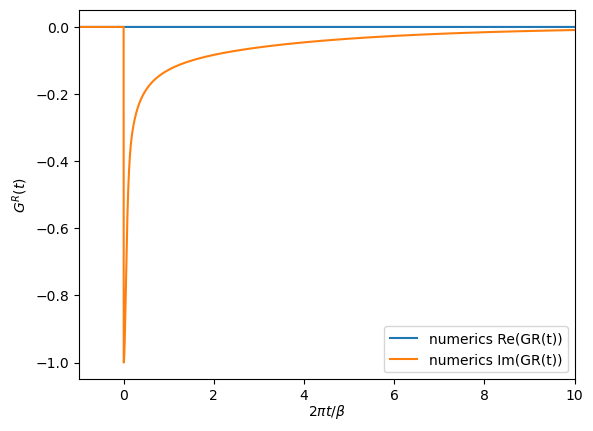

In [6]:
fig, ax = plt.subplots(1)

ax.plot(2*np.pi*t/beta, np.real(GRt), label = r'numerics Re(GR(t))')
ax.plot(2*np.pi*t/beta, np.imag(GRt), label = r'numerics Im(GR(t))')
#ax.plot(tau/beta, np.real(Gconftau), 'b--', label = 'analytical Gtau' )
#ax.set_ylim(-1,1)
ax.set_xlim(-1,10)
ax.set_xlabel(r'$2\pi t/\beta$',labelpad = 0)
ax.set_ylabel(r'${G^R(t)}$')
ax.legend()

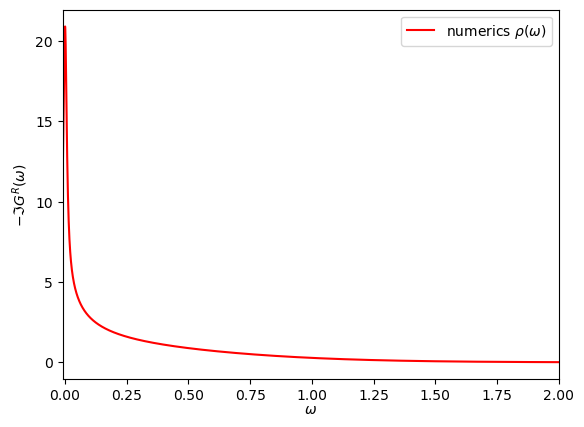

In [7]:
plt.plot(omega, rho, 'r', label = r'numerics $\rho(\omega)$')
#plt.set_ylim(-1,1)
# plt.xlim(-0.1,0.1)
plt.xlim(-0.01,2)
plt.xlabel(r'$\omega$',labelpad = 0)
plt.ylabel(r'$-\Im{G^R(\omega)}$')
plt.legend()

slope of fit = -0.627
2\Delta - 1 =  -0.5


<>:15: SyntaxWarning: invalid escape sequence '\D'
<>:15: SyntaxWarning: invalid escape sequence '\D'
/var/tmp/shankar/ipykernel_1326496/643097328.py:15: SyntaxWarning: invalid escape sequence '\D'
  print('2\Delta - 1 = ', 2*delta-1)


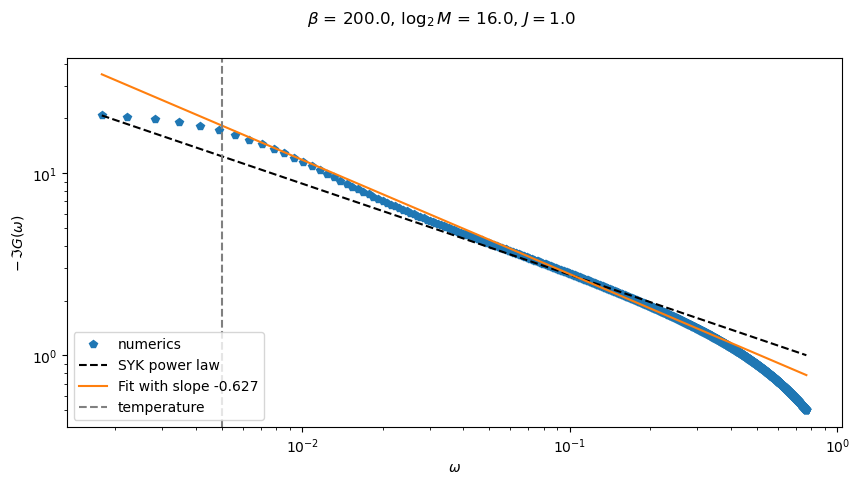

In [15]:
#delta = 0.420374134464041
delta = 0.25
start,stop = M+1, M+1000

fitG_val = -np.imag(GRomega[start])
conf_fit_G = 1 * np.abs(omega+1j*eta)**(2*delta - 1)
conf_fit_G = conf_fit_G/conf_fit_G[start] * fitG_val
# fitslice = slice(omega_idx(temp*2.,dw,M)+1, omega_idx(temp*20,dw,M)+1)
fitslice = slice(omega_idx(0.04,dw,M), omega_idx(0.4,dw,M))
#fitslice = slice(start+10, start + 20)
#fitslice = slice(start+25, start + 35)
functoplot = -np.imag(GRomega)
m,c = np.polyfit(np.log(np.abs(omega[fitslice]+1j*eta)), np.log(functoplot[fitslice]),1)
print(f'slope of fit = {m:.03f}')
print('2\Delta - 1 = ', 2*delta-1)

fig, ax1 = plt.subplots(1)
fig.set_figwidth(10)
titlestring = r'$\beta$ = ' + str(beta) + r', $\log_2{M}$ = ' + str(np.log2(M)) + r', $J = $' + str(J)
fig.suptitle(titlestring)

ax1.loglog(np.abs(omega[start:stop]+1j*eta), -np.imag(GRomega[start:stop]),'p',label = 'numerics')
#ax1.loglog(omega[start:stop], np.abs(GRomega[start:stop]),'p',label = 'numerics')
ax1.loglog(np.abs(omega[start:stop]+1j*eta), conf_fit_G[start:stop],'k--',label = 'SYK power law')
ax1.loglog(np.abs(omega[start:stop]+1j*eta),np.exp(c)*np.abs(omega[start:stop]+1j*eta)**m, label=f'Fit with slope {m:.03f}')
#ax1.set_xlim(1e-3,1e-1)
ax1.axvline([temp],ls = '--', c= 'gray',label = 'temperature')

ax1.set_xlabel(r'$\omega$')
ax1.set_ylabel(r'$-\,\Im{G(\omega)}$')
#ax1.set_ylabel(r'$|G(\omega)|$')
#ax1.set_aspect('equal', adjustable='box')
#ax1.axis('square')
ax1.legend(loc = 'lower left')
#ax1.text(0.05,100,f'slope of fit = {m:.03f}')


0.02914563496982718
slope of fit = -0.547
2\Delta - 1 =  -0.5
slope of fit = 0.511


<>:23: SyntaxWarning: invalid escape sequence '\D'
<>:23: SyntaxWarning: invalid escape sequence '\D'
/var/tmp/shankar/ipykernel_1326496/3625231448.py:23: SyntaxWarning: invalid escape sequence '\D'
  print('2\Delta - 1 = ', 2*delta-1)
/var/tmp/shankar/ipykernel_1326496/3625231448.py:6: RuntimeWarning: divide by zero encountered in power
  conf_fit_G = 1 * np.abs(omega)**(2*delta - 1)


Text(0.02, 20, 'slope of fit = -0.547')

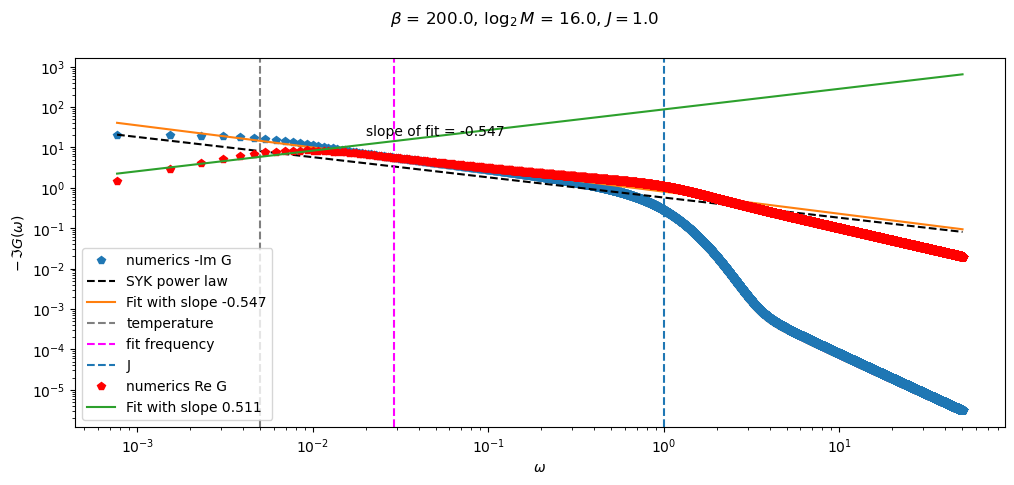

In [9]:
#delta = 0.420374134464041
delta = 0.25
start,stop = M+1, M+1000000

fitG_val = -np.imag(GRomega[start])
conf_fit_G = 1 * np.abs(omega)**(2*delta - 1)
conf_fit_G = conf_fit_G/conf_fit_G[start] * fitG_val

temp_idx = omega_idx(temp,dw,M)

fit_om = np.sqrt(temp*J)
fit_om = omega[np.argmin(np.abs(np.real(GRomega) + np.imag(GRomega)))]
print(fit_om)
#fitslice = slice(omega_idx(temp*5.,dw,M)+1, omega_idx(temp*20,dw,M)+1)
fitslice = slice(omega_idx(fit_om,dw,M)-10, omega_idx(fit_om,dw,M)+10)
#fitslice = slice(omega_idx(0.01,dw,M), omega_idx(0.1,dw,M))
#fitslice = slice(start+10, start + 20)
#fitslice = slice(start+25, start + 35)
#functoplot = -np.imag(GRomega)
functoplot = 0.5*(np.real(GRomega) - np.imag(GRomega))
m,c = np.polyfit(np.log(np.abs(omega[fitslice])), np.log(functoplot[fitslice]),1)
print(f'slope of fit = {m:.03f}')
print('2\Delta - 1 = ', 2*delta-1)

fig, ax1 = plt.subplots(1)
fig.set_figwidth(12)
titlestring = r'$\beta$ = ' + str(beta) + r', $\log_2{M}$ = ' + str(np.log2(M)) + r', $J = $' + str(J)
fig.suptitle(titlestring)

ax1.loglog(np.abs(omega[start:stop]), -np.imag(GRomega[start:stop]),'p',label = 'numerics -Im G')
#ax1.loglog(omega[start:stop], np.abs(GRomega[start:stop]),'p',label = 'numerics')
ax1.loglog(np.abs(omega[start:stop]), conf_fit_G[start:stop],'k--',label = 'SYK power law')
ax1.loglog(np.abs(omega[start:stop]),np.exp(c)*np.abs(omega[start:stop])**m, label=f'Fit with slope {m:.03f}')
#ax1.set_xlim(1e-3,1e-1)
ax1.axvline([temp],ls = '--', c= 'gray',label = 'temperature')
ax1.axvline([fit_om],ls = '--', c= 'magenta',label = 'fit frequency')
ax1.axvline([J],ls = '--', label = 'J' )

ax1.loglog(np.abs(omega[start:stop]), np.real(GRomega[start:stop]),'p',label = 'numerics Re G',c='red')

fitslice1 = slice(M+1, M+20)
functoplot1 = np.real(GRomega)
m1,c1 = np.polyfit(np.log(np.abs(omega[fitslice1])), np.log(functoplot1[fitslice1]),1)
print(f'slope of fit = {m1:.03f}')
ax1.loglog(np.abs(omega[start:stop]),np.exp(c1)*np.abs(omega[start:stop])**m1, label=f'Fit with slope {m1:.03f}')

ax1.set_xlabel(r'$\omega$')
ax1.set_ylabel(r'$-\,\Im{G(\omega)}$')
#ax1.set_ylabel(r'$|G(\omega)|$')
#ax1.set_aspect('equal', adjustable='box')
#ax1.axis('square')
ax1.legend(loc = 'lower left')
ax1.text(0.02,20,f'slope of fit = {m:.03f}')

#plt.savefig('KoenraadEmails/SYK_realtime_powerlaw.pdf')




In [10]:
omega_idx?

Signature: omega_idx(omegaval, dw, M)
Docstring:
returns the index of omegaval on the conventional omega grid
omega[M] = 0
File:      /data1/shankar/TwoSidedYSYK/ClusterScript/Sources/SYK_fft.py
Type:      function

In [11]:
fitslice

slice(65564, 65584, None)

In [12]:
eta

0.001610679827277295